In [19]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.stats as st

%matplotlib inline

In [20]:
def vasicek(r0, K, theta, sigma, T, N_split, N_sample = 1000):
    dt = T/float(N_split)
    rate = np.ones(N_sample) * r0
    for i in range(N_split):
        dr = K*(theta-rate)*dt + sigma*np.random.normal(size = N_sample)
        rate = rate + dr
    return rate

def exact_zcb(theta, kappa, sigma, tau, r0=0.):
    B = (1 - np.exp(-kappa*tau)) / kappa
    A = np.exp((theta-(sigma**2)/(2*(kappa**2))) * (B-tau) - (sigma**2)/(4*kappa)*(B**2))
    return A * np.exp(-r0*B)

def calc_Callable_Price(r0, coupon, K, theta, sigma, kappa, call_price, N_split, N_sample, T, t, n = 2, face_value=100, call = True):
    time_step = 1.0 / n
    r1 = vasicek(r0, kappa, theta, sigma, t, N_split, N_sample)
    price_1 = np.zeros(N_sample)
    for time in np.arange(time_step, T - t + time_step, time_step):
        price_1 = price_1 + (coupon * face_value / n) * exact_zcb(theta, kappa, sigma, time, r1)
    price_1 = price_1 + face_value * exact_zcb(theta, kappa, sigma, T - t, r1)
    
    price_1_est = np.sum(price_1) / N_sample

    # compare with K
    if call:
        price_1_est = min(price_1_est, call_price)
    
    price_1_est = price_1_est * exact_zcb(theta, kappa, sigma, t, r0)
    # coupon before option exercise
    for time in np.arange(0, t + time_step, time_step):
        price_1_est = price_1_est + (coupon * face_value / n) * exact_zcb(theta, kappa, sigma, time, r0)
    
    return price_1_est

# T: Bond Maturity
def get_yield_from_shortrate(theta, kappa, sigma, time, r0, T):
    y = -np.log(exact_zcb(theta, kappa, sigma, time, r0))/(T)
    
    return y
    

# Callable vs. Vanilla
## Underlying a zero coupon bond

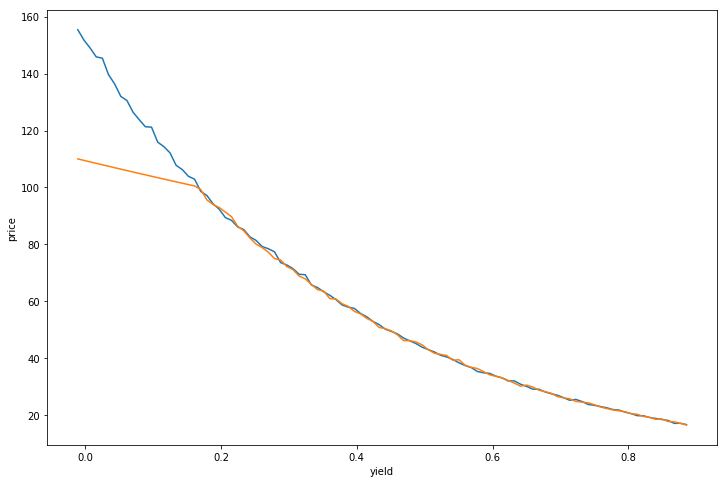

In [21]:
r0 = 0.02
K = 0.2
kappa = 0.02
theta = 0.01
sigma = 0.012

T = 10
t = 1
split = 10
coupon = 0
face_value = 100
call_price = 110

N = 1000
n = 2

interval = 0.001

price = []
initial_r = np.arange(0, 0.1, interval)
y = get_yield_from_shortrate(theta, kappa, sigma, T, initial_r, t);
for r0 in initial_r:
    price.append(calc_Callable_Price(r0, coupon, K, theta, sigma, kappa, call_price, N_split = 10, N_sample= 10000, T = 30, t = 5, call = False))
    
    
price_call = []
for r0 in initial_r:
    price_call.append(calc_Callable_Price(r0, coupon, K, theta, sigma, kappa, call_price, N_split = 10, N_sample= 10000, T = 30, t = 5))
    
    
price = np.array(price)
price_call = np.array(price_call)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot(y, price)
ax.plot(y, price_call)
ax.set_xlabel('yield')
ax.set_ylabel('price')

# Option value

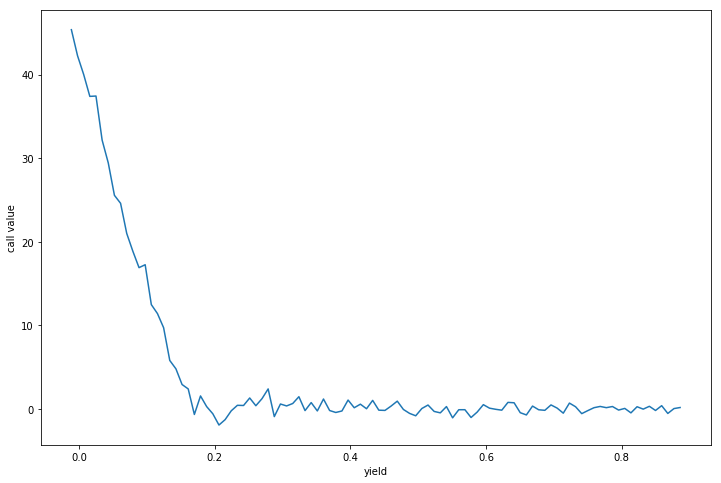

In [22]:
value = price - price_call

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot(y, value)
ax.set_xlabel('yield')
ax.set_ylabel('call value')

# Duration of callable bond

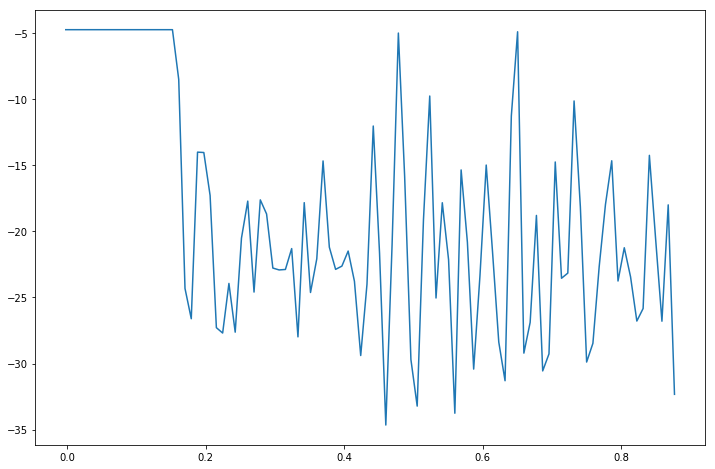

In [23]:
delta_price = (price_call[2:] - price_call[:-2])/price_call[:-2]
delta_yield = interval * 2

duration = delta_price/delta_yield

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot(y[1:-1], duration)